# Step 0: Download imports and dependencies.

In [ ]:
# Downgrade NumPy to a 1.x release that Surprise supports,
# reinstall Surprise, then restart the runtime.
!pip install --upgrade "numpy<2.0.0" scikit-surprise --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 173.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 350.5 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505202 sha256=011d0faa1dabbb497b3852e2d0b0eb3c949b7417e55d72caed2e559d9d8e240a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ip7ss3xu/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

In [ ]:
# After this cell above finishes, runtime will be reset. Do not worry that is intended, just continue running cells after this one
import os
os.kill(os.getpid(), 9)

This code block will kill the Colab runtime, but you will not need to reconnect the runtime manually. This will be done automatically. The runtime on the top right of the screen should still be active, which is expected. Continue to run the code below as normal.

In [ ]:
# Install Surprise if needed
!pip install scikit-surprise

# Step 1: Load the Last.fm dataset and inspect its structure.
* Dataset includes user-artist play counts
* Format: user_id, artist_id, artist_name, play_count

In [ ]:
from google.colab import files, drive
uploaded = files.upload()

drive.mount('/content/drive')

Saving Last.fm_data.csv to Last.fm_data.csv
Mounted at /content/drive


# Step 2: Preprocess the data
* Normalize play counts or convert to ratings (optional)
* Filter out artists or users with very few interactions
* Create a user-artist interaction matrix

In [ ]:
import pandas as pd
import numpy as np

# Specify the path to your dataset
dataset_path = 'Last.fm_data.csv'

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(dataset_path)

# Inspect the first few rows to see the data structure
print("First 5 rows of the dataset:")
print(df.head())

# Display summary information about the DataFrame,
# including column types and non-null counts
print("\nDataset information:")
print(df.info())

# (Optional) Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

# (Optional) View basic statistics for numerical columns like play_count
print("\nSummary statistics:")
print(df.describe())

#dropping ID column (1st col)
df = df.drop(columns=[df.columns[0]])

#Aggregate play counts
user_artist_plays = df.groupby(['Username', 'Artist']).size().reset_index(name='playcount')

#Normalize play counts per user
user_artist_plays['normalized_plays'] = user_artist_plays.groupby('Username')['playcount'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9) #1e-9 avoids division by zero
)

#Filter users with fewer than 5 artists
user_counts = user_artist_plays['Username'].value_counts()
filtered_df = user_artist_plays[user_artist_plays['Username'].isin(user_counts[user_counts >= 5].index)]

#Filter artists with fewer than 5 users
artist_counts = filtered_df['Artist'].value_counts()
filtered_df = filtered_df[filtered_df['Artist'].isin(artist_counts[artist_counts >= 5].index)]

#User-artist interaction matrix
interaction_matrix = filtered_df.pivot_table(
    index='Username',
    columns='Artist',
    values='normalized_plays',
    fill_value=0
)

#If we wanted to drop artists that have all zeros after normalization we can use the following:
#interaction_matrix = interaction_matrix.loc[:, (interaction_matrix != 0).any(axis=0)]


print("\nUser-Artist Interaction Matrix:")
print(interaction_matrix.head())

First 5 rows of the dataset:
   Unnamed: 0 Username           Artist                          Track  \
0           0  Babs_05  Isobel Campbell     The Circus Is Leaving Town   
1           1  Babs_05  Isobel Campbell                   Dusty Wreath   
2           2  Babs_05  Isobel Campbell     Honey Child What Can I Do?   
3           3  Babs_05  Isobel Campbell  It's Hard To Kill A Bad Thing   
4           4  Babs_05  Isobel Campbell                Saturday's Gone   

                       Album         Date    Time  
0  Ballad of the Broken Seas  31 Jan 2021   23:36  
1  Ballad of the Broken Seas  31 Jan 2021   23:32  
2  Ballad of the Broken Seas  31 Jan 2021   23:28  
3  Ballad of the Broken Seas  31 Jan 2021   23:25  
4  Ballad of the Broken Seas  31 Jan 2021   23:21  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166153 entries, 0 to 166152
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 


## Step 3: Train a collaborative filtering model
* Use the Surprise library for Matrix Factorization (SVD)
* Evaluate using RMSE or top-N recommendations

In [ ]:
# --- Step 3: Train a CF model with Surprise SVD ---

# Imports
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict

# Prepare a Surprise dataset from filtered_df
# Using normalized_plays (0–1) as the “rating”
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(
    filtered_df[['Username', 'Artist', 'normalized_plays']],
    reader
)

# Split into train & test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Instantiate & train the SVD algorithm
algo = SVD(n_factors=50, lr_all=0.005, reg_all=0.02, random_state=42)

algo.fit(trainset)

# Evaluate on the test set
predictions = algo.test(testset)
print("Test RMSE:", accuracy.rmse(predictions))

# 5‑fold cross‑validation for a more robust measure
cv = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
print("Avg CV RMSE:", cv['test_rmse'].mean())

# Helper function: extract top‑N recommendations for each user
def get_top_n(preds, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in preds:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in user_ratings[:n]]
    return top_n

# Generate recommendations for all users
anti_testset = trainset.build_anti_testset()
all_preds = algo.test(anti_testset)
top5 = get_top_n(all_preds, n=5)

# Example: show top‑5 artists for a specific user
example_user = filtered_df['Username'].unique()[0]
print(f"Top 5 recommendations for {example_user}: {top5[example_user]}")

RMSE: 0.0498
Test RMSE: 0.049809232764141016
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0528  0.0497  0.0547  0.0495  0.0516  0.0517  0.0019  
Fit time          0.10    0.12    0.11    0.11    0.11    0.11    0.01    
Test time         0.01    0.01    0.01    0.01    0.03    0.02    0.01    
Avg CV RMSE: 0.051682596138753104
Top 5 recommendations for Babs_05: ['Depeche Mode', 'James Blake', 'Mary Lou Williams', 'Kendrick Lamar', 'Tim Hecker']


## Step 4:  Generate top 5 artist recommendations for a given user

* Visualize the results in a simple interface or table
* Add content-based filtering based on artist tags/genres
* Create a Streamlit app to let users input favorite artists

In [ ]:
# Ensure that matplotlib plots display inline in Google Colab
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

def display_top5_bar(user_id, top5_dict):
  """
  display a horizontal bar chart of top 5 artist recommendations
  """
  if user_id not in top5_dict:
      print(f"No recommendations found for {user_id}")
      return

  recommended_artists = top5_dict[user_id]

  # We're using mock scores [5, 4, 3, 2, 1] just to visually represent the ranking of each recommended artist.
  scores = [5 - i for i in range(len(recommended_artists))]

   # Create a figure and axis for the bar chart
  fig, ax = plt.subplots()

  # Plot horizontal bars, reversed so the highest score appears at the top
  ax.barh(recommended_artists[::-1], scores[::-1])

  ax.set_xlabel("(Higher = Better)")
  ax.set_title(f"Top 5 Artist Recommendations for {user_id}")

  # Ensure layout fits and nothing is cut off
  plt.tight_layout()

  plt.show(block=False)  # force redraw in some environments (won't display without this)




--------------[massdosage]------------------
massdosage: ['Dorian Electra', 'Tim Hecker', 'Autechre', 'Ocean Waves For Sleep', 'Phoebe Bridgers']


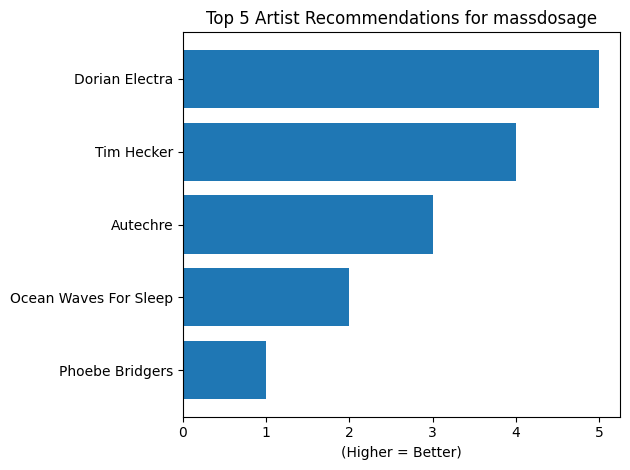


--------------[Knapster01]------------------
Knapster01: ['Depeche Mode', 'Bicep', 'James Blake', 'Caspian', 'The Beatles']


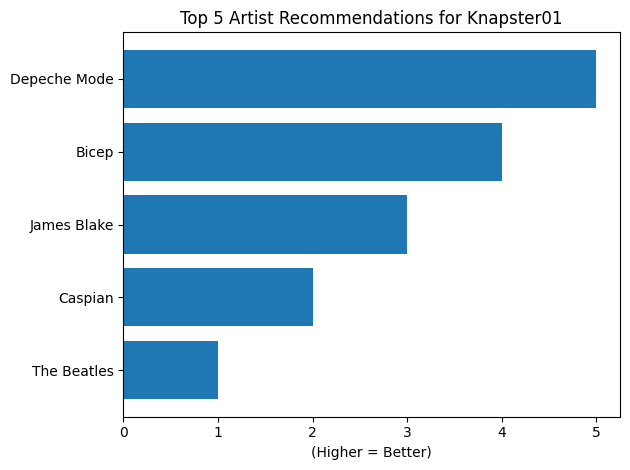


--------------[jonocole]------------------
jonocole: ['Madlib', 'Sophie', 'Radiohead', 'Dorian Electra', 'Kendrick Lamar']


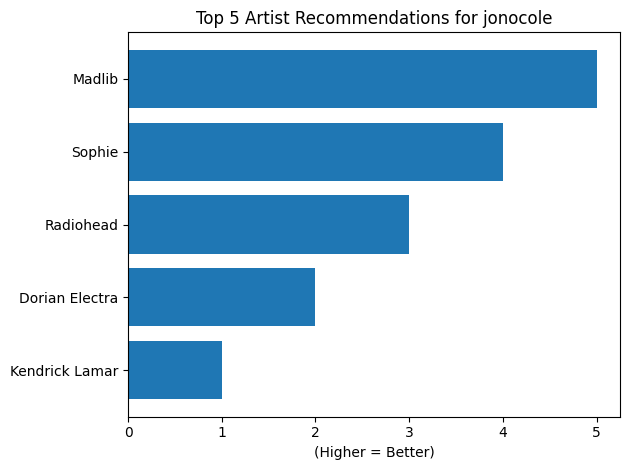


--------------[Orlenay]------------------
Orlenay: ['Madlib', 'Depeche Mode', 'Metric', 'Caspian', 'New Order']


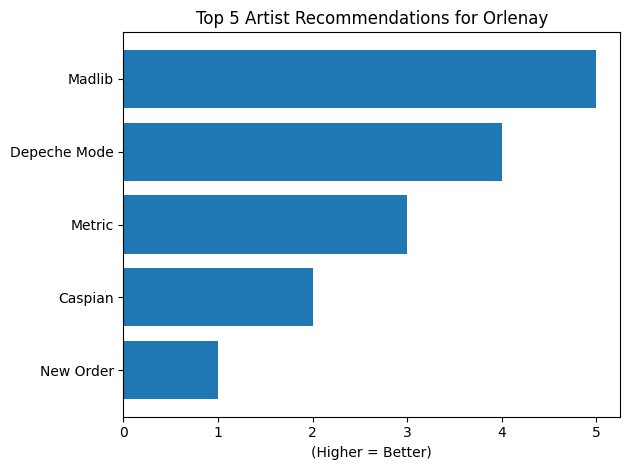


--------------[eartle]------------------
eartle: ['Johann Sebastian Bach', 'Ólafur Arnalds', 'Mary Lou Williams', 'Kendrick Lamar', 'Dorian Electra']


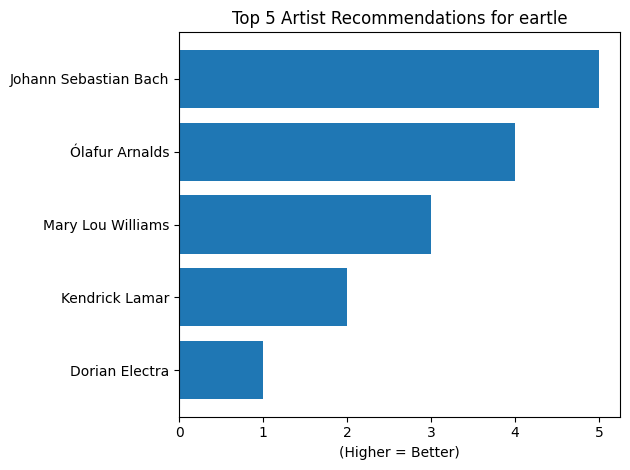

In [ ]:
# Display the top 5 recommendations as a chart for the first 5 users in the top5 dictionary
for uid, artists in list(top5.items())[:5]:
    print(f"--------------[{uid}]------------------")
    print(f"{uid}: {artists}")
    display_top5_bar(uid, top5)
    print("")

Table Graph

In [ ]:
def display_top5_table(user_id, top5_dict):
  """
  Display a table of top 5 artist recommendations
  """
  if user_id not in top5_dict:
    print(f"No recommendations found for {user_id}")
    return

  recommended_artists = top5_dict[user_id]

  df_recommend = pd.DataFrame({
      'Rank': range(1, len(recommended_artists) + 1),
      'Recommended Artist': recommended_artists
  })

  print(f"\nTop 5 Artists Recommendendations for {user_id}:")
  #print(df_recommend)

  columns = ['Rank', 'Recommended Artist']
  rows = ['1','2','3','4', '5']

  fig, ax = plt.subplots()
  ax.axis('off')

  table = ax.table(cellText=df_recommend.values, colLabels=columns, cellLoc='center', loc='center')

  plt.show()


--------------[massdosage]------------------
massdosage: ['Dorian Electra', 'Tim Hecker', 'Autechre', 'Ocean Waves For Sleep', 'Phoebe Bridgers']

Top 5 Artists Recommendendations for massdosage:


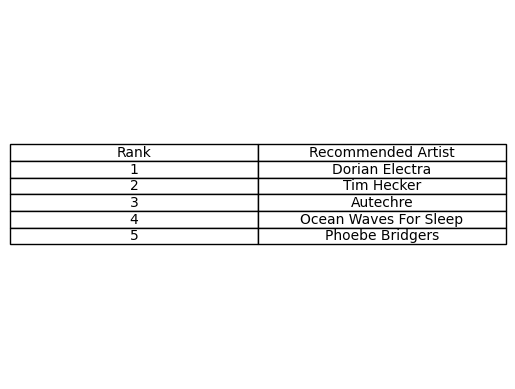


--------------[Knapster01]------------------
Knapster01: ['Depeche Mode', 'Bicep', 'James Blake', 'Caspian', 'The Beatles']

Top 5 Artists Recommendendations for Knapster01:


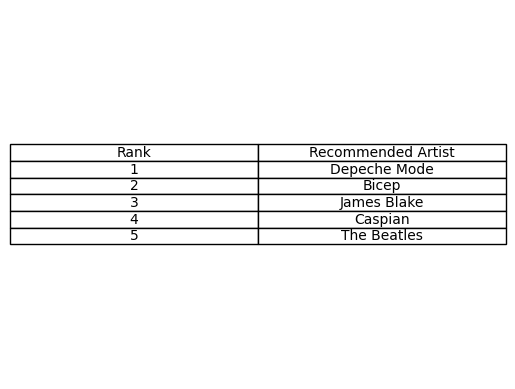


--------------[jonocole]------------------
jonocole: ['Madlib', 'Sophie', 'Radiohead', 'Dorian Electra', 'Kendrick Lamar']

Top 5 Artists Recommendendations for jonocole:


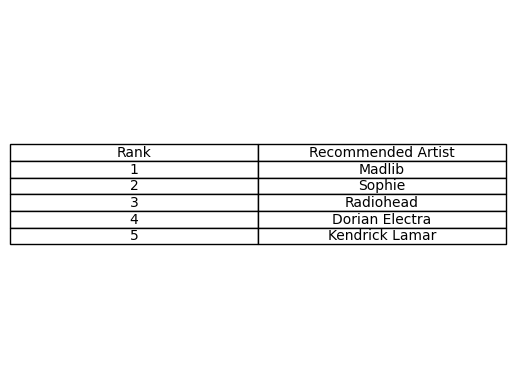


--------------[Orlenay]------------------
Orlenay: ['Madlib', 'Depeche Mode', 'Metric', 'Caspian', 'New Order']

Top 5 Artists Recommendendations for Orlenay:


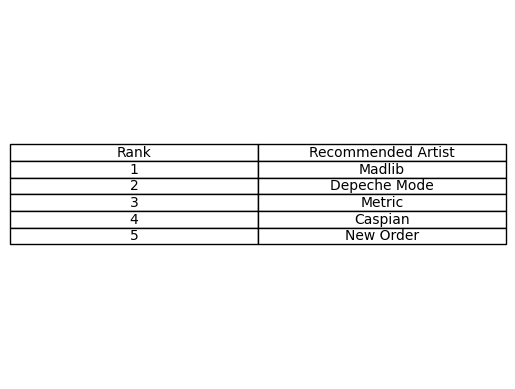


--------------[eartle]------------------
eartle: ['Johann Sebastian Bach', 'Ólafur Arnalds', 'Mary Lou Williams', 'Kendrick Lamar', 'Dorian Electra']

Top 5 Artists Recommendendations for eartle:


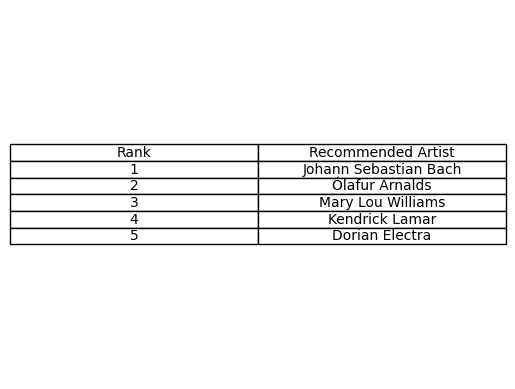

In [ ]:
for uid, artists in list(top5.items())[:5]:
    print(f"--------------[{uid}]------------------")
    print(f"{uid}: {artists}")
    display_top5_table(uid, top5)
    print("")